In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.robust.robust_linear_model import RLM


In [47]:
# set seed and current working directory
np.random.seed(123)

# current working directory
import os
os.getcwd()
os.chdir('/home/schmilor/GitHub/RiskManangementHUBerlin/')



## Introduction

Index insurances for yield risk management can be used to protect farmers from yield losses due to weather events. The index insurance is based on a weather index, such as the number of days with precipitation above a certain threshold. The insurance pays out if the index value exceeds a certain threshold. The insurance is designed to be simple and transparent, and to reduce the costs of traditional insurance.

Types of index insurance:
- Area-yield index insurance: the index is based on the average yield of a group of farmers in a certain area.	
- Weather index insurance: the index is based on weather data, such as temperature, precipitation, or humidity.

The main steps to design an index insurance are:
1. Define the index: select the index, the threshold, and the payout function.
2. Collect data: collect historical data on the index and the payouts.
3. Estimate the parameters: estimate the parameters of the index and the payouts.
4. Validate the model: validate the model using historical data.
5. Design the insurance: design the insurance contract, including the premium and the coverage.
6. Implement the insurance: implement the insurance contract and market it to farmers.



## Data
First, we load the dataset and select the relevant variables.


In [48]:
# Load the dataset
data = pd.read_csv('data/Final_data.csv')

In [49]:
# print the first 5 rows of the dataframe
data.head()

,district_no,district,nuts_id,year,var,measure,value,outlier
0,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,ArabLand,area,891.0,0
1,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,district,area,5673.0,0
2,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,grain_maize,area,NaN,0
3,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,grain_maize,yield,NaN,0
4,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,oats,area,42.0,0


In [50]:
# we only want to consider ww which stands for winter wheat
data = data[data['var'] == 'ww']

# and the years > 2000
data = data[data['year'] >= 2000]
# make to wide dataframe based on column measure and value
data = data.pivot(index=['year', 'district_no', 'district', 'nuts_id', 'var', 'outlier'], columns='measure', values='value').reset_index()
data.head()

measure,year,district_no,district,nuts_id,var,outlier,area,yield
0,2000,1001,"Flensburg, kreisfreie Stadt",DEF01,ww,0,NaN,9.86
1,2000,1002,"Kiel, kreisfreie Stadt",DEF02,ww,0,NaN,9.78
2,2000,1003,"Lübeck, kreisfreie Stadt",DEF03,ww,0,NaN,9.40
3,2000,1004,"Neumünster, kreisfreie Stadt",DEF04,ww,0,NaN,7.94
4,2000,1051,"Dithmarschen, Landkreis",DEF05,ww,0,NaN,9.72


## Description of the data

- **Year**: Year of observation
- **District_no**: District number
- **District**: District name
- **nuts_id**: NUTS ID
- **var**: Name of the crop in our case "ww" for winter wheat
- **outlier**: Outlier flag
- **area**: Area of the crop in ha
- **yield**: Yield of the crop in to/ha

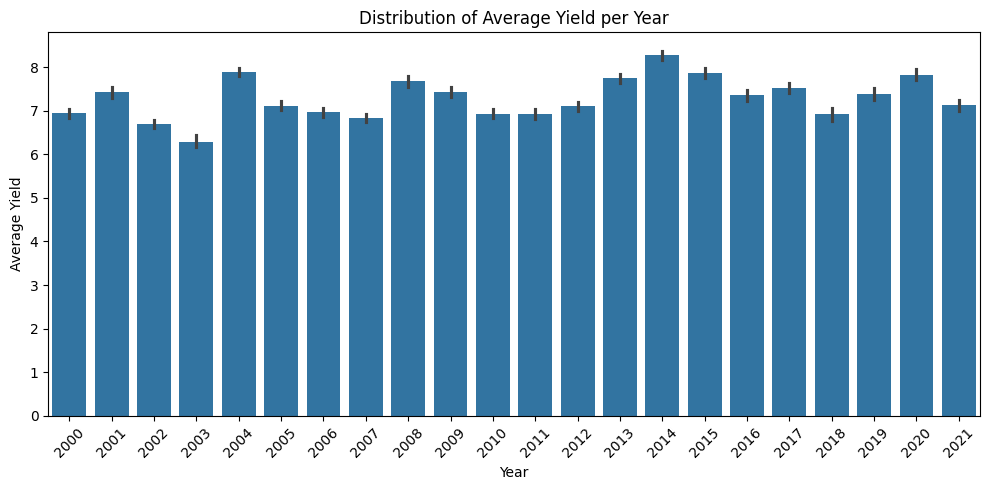

In [51]:
# plot the distribution of average yield per year as barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='year', y='yield')
plt.xlabel('Year')
plt.ylabel('Average Yield')
plt.title('Distribution of Average Yield per Year')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust the layout to prevent label overlapping
plt.show()


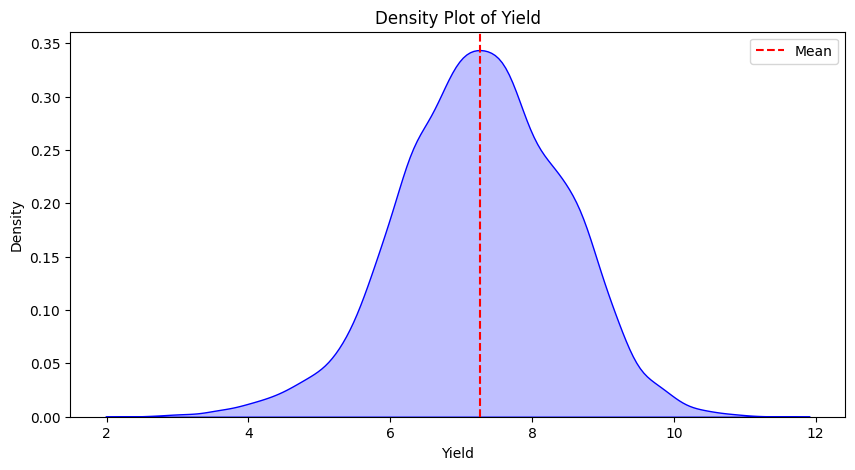

In [52]:
# density plot of yield add vertical line for mean and median

plt.figure(figsize=(10, 5))
sns.kdeplot(data['yield'], fill=True, color='b')
plt.axvline(data['yield'].mean(), color='r', linestyle='--', label='Mean')
plt.xlabel('Yield')
plt.ylabel('Density')
plt.title('Density Plot of Yield')
plt.legend()
plt.show()

In [53]:
# identify Bundesland based on first two digits of district_no
# if district_no has not 5 digits add leading zeros
data['district_no'] = data['district_no'].apply(lambda x: '{0:0>5}'.format(x))
data['bundesland'] = data['district_no'].astype(str).str[:2]

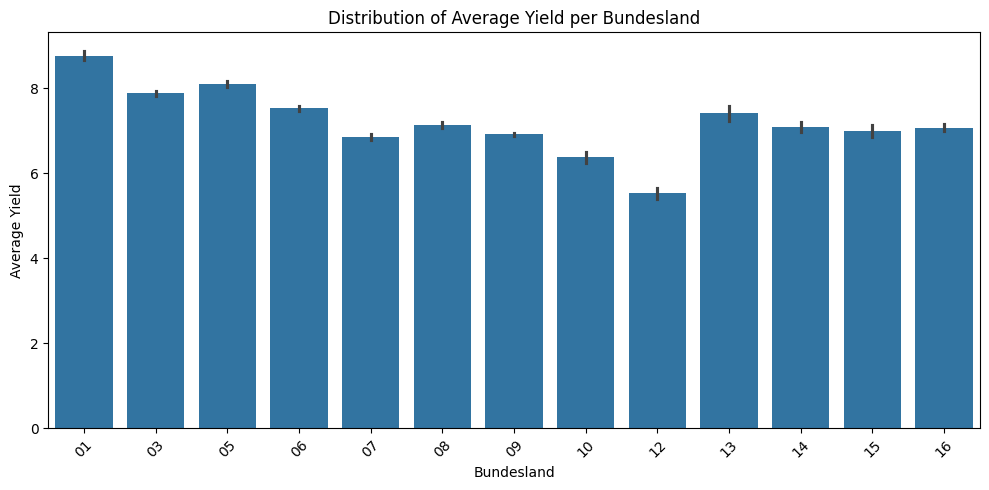

In [54]:
# plot the distribution of average yield per year as barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='bundesland', y='yield')
plt.xlabel('Bundesland')
plt.ylabel('Average Yield')
plt.title('Distribution of Average Yield per Bundesland')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust the layout to prevent label overlapping
plt.show()

### The key features of an area yield insurance are:

1. Payouts are triggered if the realized county average yield falls below a predefined strike yield
2. The payout amount is based on the difference between the realized yield and the strike yield
3. All insured farmers in the county receive the same payout per insured unit

Compared to weather index insurance, area yield insurance has the advantage that the payout is directly linked to the realized yield, which can reduce basis risk. However, it requires reliable and timely yield data at the area level.

### Detrending Yields
To avoid biased estimates of the strike yield and expected yield, we first need to detrend the yield data to remove the effect of technological progress.
We use a robust M-estimator for a linear trend:

$$y_t = \alpha + \beta t + \epsilon_t$$

where $y_t$ is yield in year $t$, $\alpha$ is the intercept, $\beta$ is the trend slope, and $\epsilon_t$ is the residual.

The detrended yield is then:

$$\tilde{y}_t = y_t - (\hat{\alpha} + \hat{\beta} t)$$

In [55]:
# drop na in yield
data = data.dropna(subset=['yield'])

In [56]:
# only consider consider districts with 22 observations
data = data.groupby('district_no').filter(lambda x: len(x) == 22)

In [58]:
# some descriptive statistics
data.describe()

measure,year,outlier,area,yield,yield_detrend
count,5412.000000,5412.0,1208.000000,5412.000000,5.412000e+03
mean,2010.500000,0.0,11357.856529,7.304793,2.566724e-15
std,6.344875,0.0,11296.759130,1.134975,6.944332e-01
min,2000.000000,0.0,212.000000,2.570000,-2.777182e+00
25%,2005.000000,0.0,3837.730000,6.580000,-4.258978e-01
50%,2010.500000,0.0,7994.790000,7.300000,2.724939e-02
75%,2016.000000,0.0,14219.000000,8.080000,4.643662e-01
max,2021.000000,0.0,78441.080000,11.040000,2.326979e+00


In [59]:
# from year 2000 to 2018 for building up the area yield model
data_train = data[data['year'] <= 2018]
data_test = data[data['year'] >= 2019]

In [ ]:
# 